## Setup

### Core imports

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

### Data Cleaning imports

In [43]:
from pprint import pprint
from bs4 import BeautifulSoup
import re
from nltk.tokenize import WordPunctTokenizer

### Constants

In [2]:
DATASET = "training.1600000.processed.noemoticon.csv"
CLEAN_DATASET = "clean_tweet.csv"
TF_DATASET = "term_freq.csv"
TF_DATASET_NO_STOP_WORDS = "term_freq_no_stop_words.csv"
TF_DATASET_NO_STOP_WORDS_WITH_DISTRIBUTIONS = "term_freq_no_stop_words_dist.csv"

### Utils

In [6]:
def saveDF(df,fileName):
    df.to_csv(fileName, encoding='utf-8')

def readCSV(fileName):
    return pd.read_csv(fileName, encoding='utf-8',index_col=0)

## Data Cleaning

In [52]:
# Dataload
cols = ['sentiment','id','date','query_string','user','text']
df =  pd.read_csv(DATASET,header=None, names=cols, encoding="ISO-8859-1")
df.drop(['id','date','query_string','user'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [44]:
# Sanity check
df['pre_clean_len'] = [len(t) for t in df.text]
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 4:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}
pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 4:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


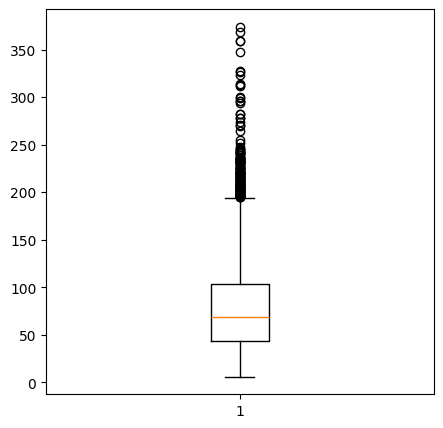

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141


In [29]:
fig, ax = plt.subplots(figsize=(5,5))
plt.boxplot(df.pre_clean_len)
plt.show()
df[df.pre_clean_len > 140].head(10)

## Tweets have at most 140 characters, but there are some registers with way more. We can see that there is a problem with the encoding

In [45]:
# HTML decoding
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [13]:
# Mentions
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [15]:
# URLs
df.text[0]
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [5]:
# Byte Order Mark (BOM)
testing = df.text[226]
print(testing)
testing.replace("ï¿½", "?")

Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers 


'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [42]:
# Hashtags
df.text[175]
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

In [46]:
# Cleaner
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.replace("ï¿½", "?")
    except:
        bom_removed = souped

    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()
testing = df.text[:100]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result

/tmp/ipykernel_3103/153555506.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


['awww that bummer you shoulda got david carr of third day to do it',
 'is upset that he can not update his facebook by texting it and might cry as result school today also blah',
 'dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it not behaving at all mad why am here because can not see you all over there',
 'not the whole crew',
 'need hug',
 'hey long time no see yes rains bit only bit lol fine thanks how you',
 'nope they did not have it',
 'que me muera',
 'spring break in plain city it snowing',
 'just re pierced my ears',
 'could not bear to watch it and thought the ua loss was embarrassing',
 'it it counts idk why did either you never talk to me anymore',
 'would ve been the first but did not have gun not really though zac snyder just doucheclown',
 'wish got to watch it with you miss you and how was the premiere',
 'hollis death scene will hurt me severely to watch on film wry is directors cut no

In [56]:
clean_df = df.copy()
clean_df.rename(columns={"sentiment":"target"},inplace=True)
clean_df['text'] = df.text.apply(tweet_cleaner)
clean_df.to_csv(CLEAN_DATASET,encoding='utf-8')

/tmp/ipykernel_3103/153555506.py:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


In [59]:
my_df = pd.read_csv(CLEAN_DATASET,index_col=0)
my_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   text    1596041 non-null  object
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [5]:
## There are some cells with null values
my_df[my_df.isnull().any(axis=1)].head()

3959

In [9]:
df = pd.read_csv(DATASET,header=None, encoding="ISO-8859-1")
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()
## They are all mentions with no words

,0,1,2,3,4,5
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
282,0,1467881474,Mon Apr 06 22:38:20 PDT 2009,NO_QUERY,__Susan__,@ITS_NEMESIS -------
398,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
430,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,NO_QUERY,jtmal0723,@anistorm


In [60]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1596041 non-null  int64 
 1   text    1596041 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [61]:
## Overwrite the previous csv
my_df['target'] = my_df['target'].replace(4,1)
my_df.to_csv(CLEAN_DATASET,encoding='utf-8')

In [3]:
## For future experiments, we load from here
my_df = pd.read_csv(CLEAN_DATASET,index_col=0)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1596041 non-null  int64 
 1   text    1596041 non-null  object
dtypes: int64(1), object(1)
memory usage: 36.5+ MB


## Data visualization

### Wordcloud

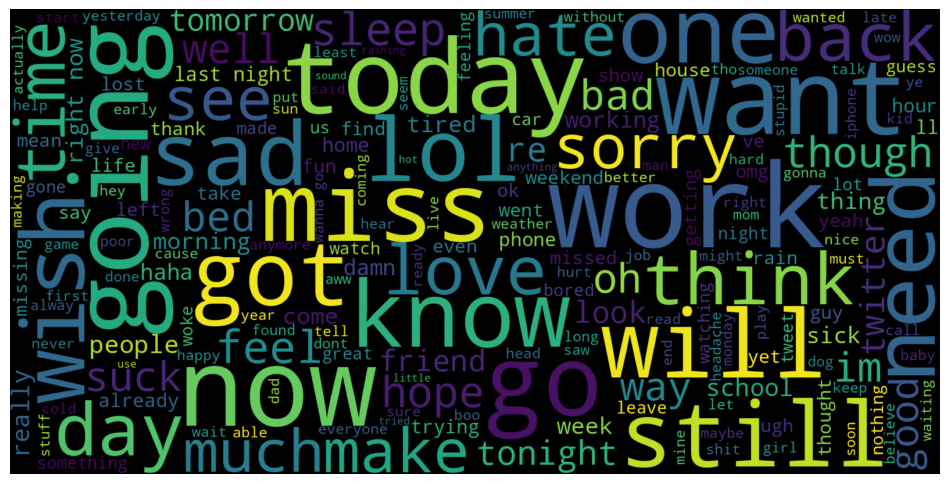

In [63]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print(t)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time do not want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people


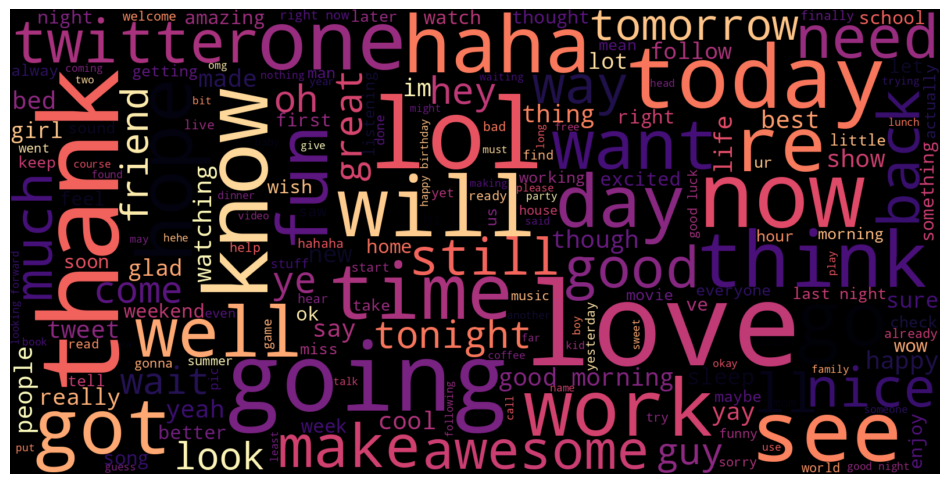

In [64]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.to_csv(TF_DATASET,encoding='utf-8')

In [7]:

term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86865,281589
is,133432,111191,244623
in,115542,101160,216702
for,98999,117369,216368


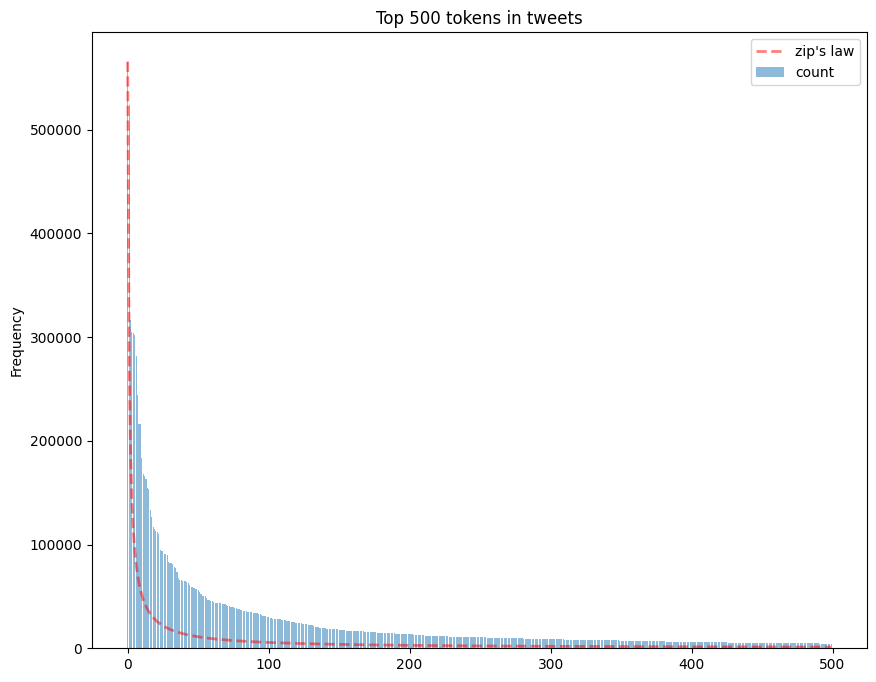

In [64]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df['total'].max()/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df['total'].nlargest(500), align='center', alpha=0.5, label='count')
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5, label = 'zip\'s law')
plt.legend()
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')
plt.show()

/tmp/ipykernel_564/3872343310.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frequencies = counts[indices]
/tmp/ipykernel_564/3872343310.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
/tmp/ipykernel_564/3872343310.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]],


<Figure size 640x480 with 0 Axes>

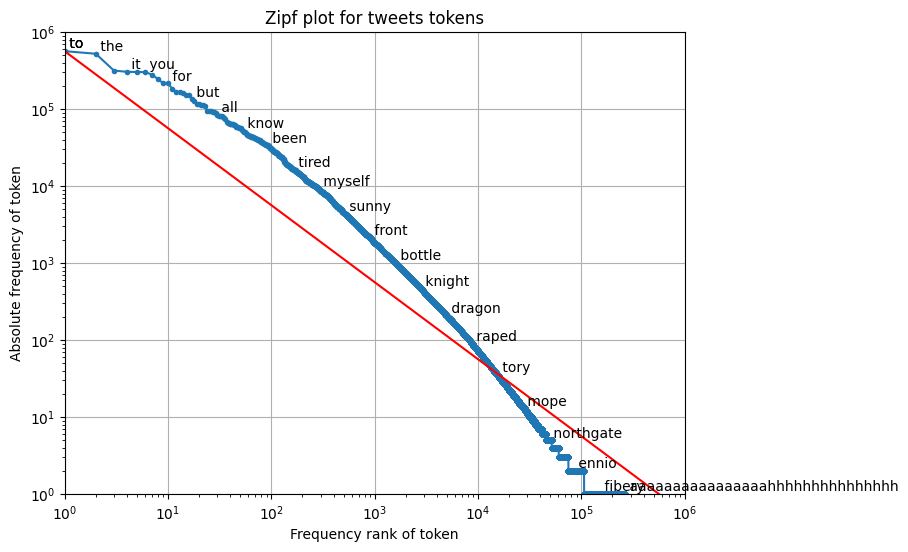

In [70]:
from pylab import *
plt.clf()
counts = term_freq_df.total
tokens = counts.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)

frequencies = frequencies.astype(float)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")
plt.show()

In [94]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english', max_features=10000)
cvec.fit(my_df.text)
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names_out()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.to_csv(TF_DATASET_NO_STOP_WORDS,encoding='utf-8')

In [95]:
term_freq_df2 = pd.read_csv(TF_DATASET_NO_STOP_WORDS,index_col=0)

,negative,positive,total
aa,160,92,252
aaa,93,54,147
aaaa,45,29,74
aaaah,76,61,137
aaaand,33,37,70
...,...,...,...
zune,87,57,144
zzz,88,96,184
zzzz,53,65,118
zzzzz,44,47,91


<Figure size 640x480 with 0 Axes>

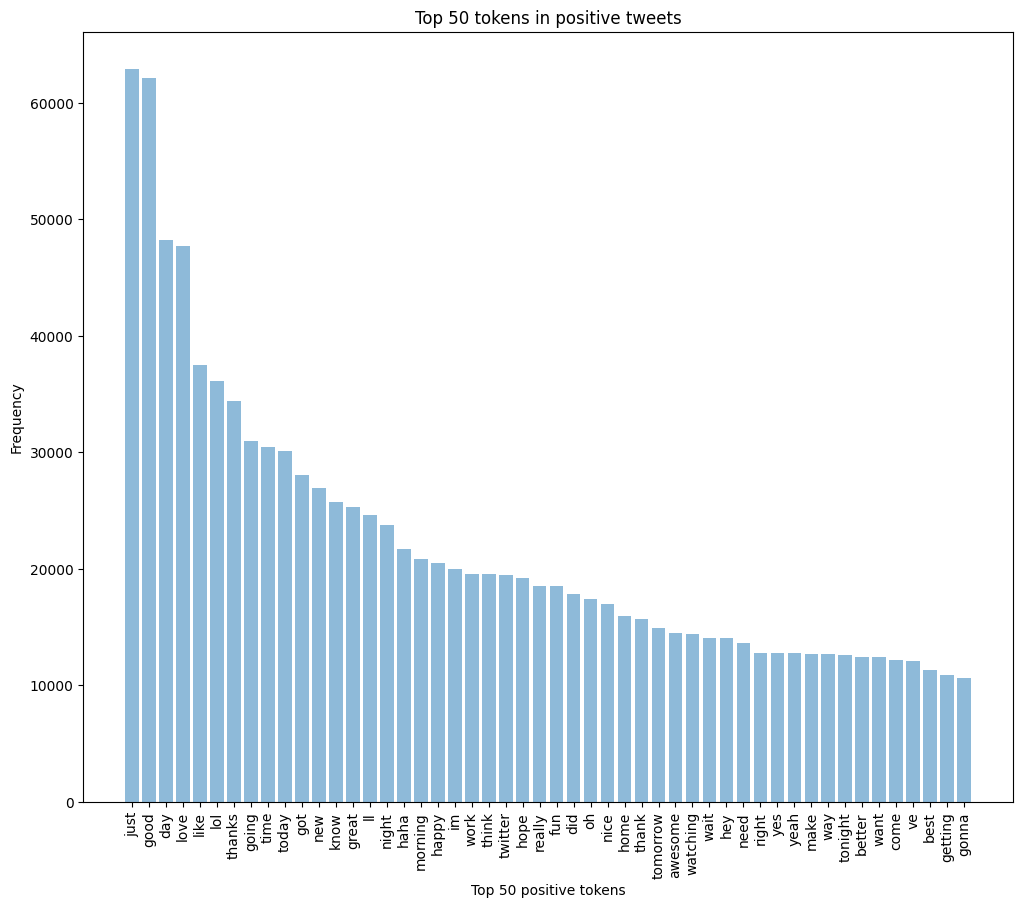

In [100]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')
plt.show()

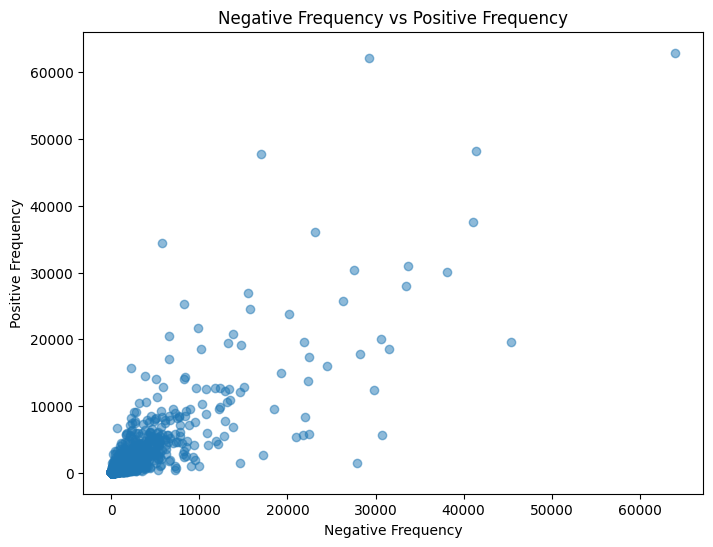

In [102]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')
plt.show()

In [103]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
mileymonday,0,161,161,1.000000
emailunlimited,0,100,100,1.000000
dividends,0,83,83,1.000000
shareholder,1,80,81,0.987654
fuzzball,2,99,101,0.980198
recommends,3,109,112,0.973214
delongeday,6,162,168,0.964286
atcha,3,80,83,0.963855
timestamp,3,68,71,0.957746
shaundiviney,4,89,93,0.956989


In [106]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
just,64004,62944,126948,0.495825,0.014396
good,29209,62118,91327,0.680171,0.014207
day,41374,48186,89560,0.538030,0.011020
love,16990,47694,64684,0.737338,0.010908
like,41050,37520,78570,0.477536,0.008581
lol,23123,36118,59241,0.609679,0.008260
thanks,5768,34375,40143,0.856314,0.007862
going,33689,30939,64628,0.478724,0.007076
time,27526,30432,57958,0.525070,0.006960
today,38116,30100,68216,0.441245,0.006884


In [108]:
from scipy.stats import hmean
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
just,64004,62944,126948,0.495825,0.014396,0.027979
good,29209,62118,91327,0.680171,0.014207,0.027832
day,41374,48186,89560,0.538030,0.011020,0.021598
love,16990,47694,64684,0.737338,0.010908,0.021498
like,41050,37520,78570,0.477536,0.008581,0.016859
lol,23123,36118,59241,0.609679,0.008260,0.016300
thanks,5768,34375,40143,0.856314,0.007862,0.015580
going,33689,30939,64628,0.478724,0.007076,0.013946
time,27526,30432,57958,0.525070,0.006960,0.013738
today,38116,30100,68216,0.441245,0.006884,0.013557


In [120]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
welcome,620,6702,7322,0.915324,0.001533,0.003060,0.995631,0.999369,0.997497,0.084676,0.000135,0.000270,0.004369,0.533257,0.008667
thank,2282,15736,18018,0.873349,0.003599,0.007168,0.990801,1.000000,0.995379,0.126651,0.000498,0.000993,0.009199,0.826121,0.018194
thanks,5768,34375,40143,0.856314,0.007862,0.015580,0.987780,1.000000,0.993853,0.143686,0.001260,0.002498,0.012220,0.996865,0.024144
awesome,3821,14469,18290,0.791088,0.003309,0.006591,0.967042,1.000000,0.983245,0.208912,0.000835,0.001662,0.032958,0.958285,0.063725
glad,2273,8255,10528,0.784100,0.001888,0.003767,0.963668,0.999971,0.981484,0.215900,0.000496,0.000991,0.036332,0.824929,0.069598
follow,2552,9154,11706,0.781992,0.002094,0.004176,0.962597,0.999996,0.980940,0.218008,0.000557,0.001112,0.037403,0.859466,0.071686
enjoy,1642,5876,7518,0.781591,0.001344,0.002683,0.962390,0.997441,0.979602,0.218409,0.000359,0.000716,0.037610,0.728909,0.071529
sweet,1610,5646,7256,0.778115,0.001291,0.002578,0.960559,0.996331,0.978118,0.221885,0.000352,0.000702,0.039441,0.723425,0.074803
yay,3165,10501,13666,0.768403,0.002402,0.004788,0.955057,1.000000,0.977012,0.231597,0.000691,0.001378,0.044943,0.918259,0.085692
hello,1122,4524,5646,0.801275,0.001035,0.002067,0.971493,0.982293,0.976863,0.198725,0.000245,0.000490,0.028507,0.633770,0.054559


In [131]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
saveDF(term_freq_df2,TF_DATASET_NO_STOP_WORDS_WITH_DISTRIBUTIONS)
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
sad,27911,1510,29421,0.051324,0.000345,0.000686,0.002370,0.709589,0.004725,0.948676,0.006096,0.012114,0.997630,1.000000,0.998813
hurts,7204,456,7660,0.059530,0.000104,0.000208,0.002782,0.503851,0.005533,0.940470,0.001573,0.003142,0.997218,0.999742,0.998479
sick,14617,1419,16036,0.088488,0.000325,0.000647,0.004800,0.693341,0.009535,0.911512,0.003192,0.006363,0.995200,1.000000,0.997594
sucks,9902,982,10884,0.090224,0.000225,0.000448,0.004955,0.610416,0.009830,0.909776,0.002163,0.004315,0.995045,0.999999,0.997516
poor,7333,719,8052,0.089295,0.000164,0.000328,0.004872,0.557656,0.009659,0.910705,0.001602,0.003198,0.995128,0.999799,0.997458
ugh,9056,998,10054,0.099264,0.000228,0.000455,0.005835,0.613572,0.011560,0.900736,0.001978,0.003947,0.994165,0.999995,0.997072
missing,7282,991,8273,0.119787,0.000227,0.000452,0.008365,0.612192,0.016504,0.880213,0.001590,0.003175,0.991635,0.999778,0.995690
headache,5317,421,5738,0.073371,0.000096,0.000192,0.003624,0.496664,0.007196,0.926629,0.001161,0.002320,0.996376,0.993811,0.995091
hate,17207,2614,19821,0.131880,0.000598,0.001190,0.010269,0.868739,0.020298,0.868120,0.003758,0.007484,0.989731,1.000000,0.994839
miss,30713,5676,36389,0.155981,0.001298,0.002575,0.015215,0.996497,0.029972,0.844019,0.006708,0.013310,0.984785,1.000000,0.992334


<Figure size 640x480 with 0 Axes>

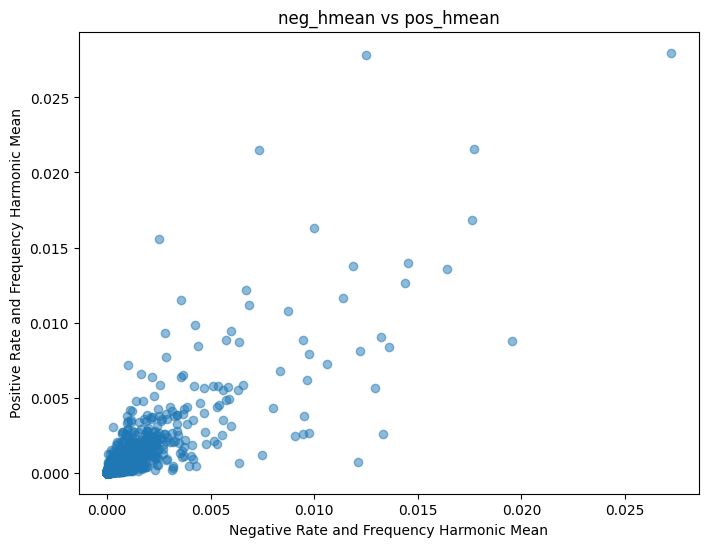

In [122]:
plt.clf()
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')
plt.show()

<Figure size 800x600 with 0 Axes>

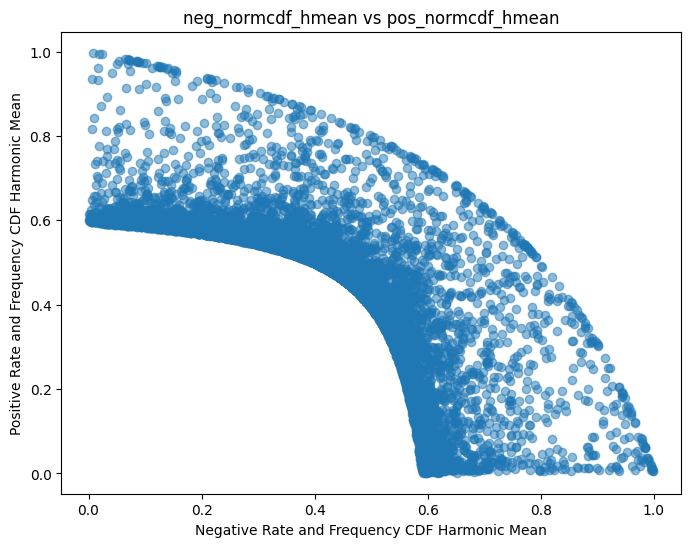

In [124]:
plt.clf()
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')
plt.show()

In [126]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

In [8]:
my_df = readCSV(CLEAN_DATASET)

In [3]:
from sklearn.model_selection import train_test_split

In [9]:
x = my_df.text
y = my_df.target
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x,y,test_size=.02,random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

def showSets(name, x, y):
    print("{0} set has a total {1} entries with {2:.2f}% negative, {3:.2f}% positive".format(name,len(x), (len(x[y == 0]) / (len(x)*1.))*100, (len(x[y == 1]) / (len(x)*1.))*100))

showSets("Training", x_train, y_train)
showSets("Validation", x_validation, y_validation)
showSets("Testing", x_test, y_test)

Training set has a total 1564120 entries with 50.02% negative, 49.98% positive
Validation set has a total 15960 entries with 49.45% negative, 50.55% positive
Testing set has a total 15961 entries with 49.68% negative, 50.32% positive


In [40]:
x_test[y_test == 0]

279501                 this does not help my fear of flying
120645    iv got feeling im going to do bad in re exam u...
187862              argh keep getting distracted from maths
526699          my burger king coke tastes like purrrrrfume
765572    gutted that your double heart personalised nec...
                                ...                        
326774       our condolences hang on to those good memories
609884    terrible you wernt even there last night real ...
50691                        aww can not join need to study
634177    hope get to sleep in tomorrow working in my da...
413732    just biked home froze my ass off but got good ...
Name: text, Length: 7929, dtype: object

#### Baseline

In [10]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0], normalize = 'true'))
confusion = pd.DataFrame(conmat, index=['positive','negative'], columns=['predicted_positive', 'predicted_negative'])

print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation,tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Clasification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 61.84%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive            0.902690            0.097310
negative            0.672241            0.327759
--------------------------------------------------------------------------------
Clasification Report

              precision    recall  f1-score   support

           0       0.77      0.33      0.46      7893
           1       0.58      0.90      0.71      8067

    accuracy                           0.62     15960
   macro avg       0.67      0.62      0.58     15960
weighted avg       0.67      0.62      0.58     15960



In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [13]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    auxAcc = len(x_test[y_test == 0]) / (len(x_test)*1.) 
    null_accuracy = max(1-auxAcc, auxAcc)
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time(
        
    ) - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time
cvec = CountVectorizer()
lr = LogisticRegression(max_iter=200)
n_features = np.arange(10000,100001,10000)
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [14]:
nfeature_accuracy_checker()

LogisticRegression(max_iter=200)


Validation result for 10000 features


/home/facutotaro/local/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.58%
model is 29.04% more accurate than null accuracy
train and test time: 74.98s
--------------------------------------------------------------------------------
Validation result for 20000 features


KeyboardInterrupt: 

We check that out top 10 words are a subset of the english stop words

In [15]:
from sklearn.feature_extraction import text

term_freq_df = readCSV(TF_DATASET)
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total',ascending=False).iloc[:10].index))
set(my_stop_words).issubset(set(text.ENGLISH_STOP_WORDS))

True

We run the algorithm to obtain the results

In [18]:
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS
LogisticRegression(max_iter=200)


Validation result for 10000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.32%
model is 26.78% more accurate than null accuracy
train and test time: 56.37s
--------------------------------------------------------------------------------
Validation result for 20000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.67%
model is 27.12% more accurate than null accuracy
train and test time: 64.93s
--------------------------------------------------------------------------------
Validation result for 30000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.75%
model is 27.21% more accurate than null accuracy
train and test time: 67.96s
--------------------------------------------------------------------------------
Validation result for 40000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.70%
model is 27.16% more accurate than null accuracy
train and test time: 65.35s
--------------------------------------------------------------------------------
Validation result for 50000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.77%
model is 27.22% more accurate than null accuracy
train and test time: 66.06s
--------------------------------------------------------------------------------
Validation result for 60000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.91%
model is 27.37% more accurate than null accuracy
train and test time: 67.70s
--------------------------------------------------------------------------------
Validation result for 70000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.83%
model is 27.29% more accurate than null accuracy
train and test time: 67.99s
--------------------------------------------------------------------------------
Validation result for 80000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.83%
model is 27.28% more accurate than null accuracy
train and test time: 68.88s
--------------------------------------------------------------------------------
Validation result for 90000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.84%
model is 27.29% more accurate than null accuracy
train and test time: 68.33s
--------------------------------------------------------------------------------
Validation result for 100000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 77.81%
model is 27.27% more accurate than null accuracy
train and test time: 68.41s
--------------------------------------------------------------------------------


In [19]:
print("RESULT FOR UNIGRAM WITH STOP WORDS")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS
LogisticRegression(max_iter=200)


Validation result for 10000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.58%
model is 29.04% more accurate than null accuracy
train and test time: 67.64s
--------------------------------------------------------------------------------
Validation result for 20000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.82%
model is 29.27% more accurate than null accuracy
train and test time: 71.80s
--------------------------------------------------------------------------------
Validation result for 30000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.99%
model is 29.44% more accurate than null accuracy
train and test time: 74.86s
--------------------------------------------------------------------------------
Validation result for 40000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 80.03%
model is 29.48% more accurate than null accuracy
train and test time: 73.13s
--------------------------------------------------------------------------------
Validation result for 50000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.98%
model is 29.44% more accurate than null accuracy
train and test time: 75.58s
--------------------------------------------------------------------------------
Validation result for 60000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 80.03%
model is 29.49% more accurate than null accuracy
train and test time: 75.95s
--------------------------------------------------------------------------------
Validation result for 70000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 80.08%
model is 29.53% more accurate than null accuracy
train and test time: 75.87s
--------------------------------------------------------------------------------
Validation result for 80000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 80.01%
model is 29.46% more accurate than null accuracy
train and test time: 76.09s
--------------------------------------------------------------------------------
Validation result for 90000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 80.08%
model is 29.53% more accurate than null accuracy
train and test time: 77.27s
--------------------------------------------------------------------------------
Validation result for 100000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 80.11%
model is 29.57% more accurate than null accuracy
train and test time: 78.41s
--------------------------------------------------------------------------------


In [24]:
my_stop_words = (list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)
LogisticRegression(max_iter=200)


Validation result for 10000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 78.84%
model is 28.30% more accurate than null accuracy
train and test time: 57.48s
--------------------------------------------------------------------------------
Validation result for 20000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.03%
model is 28.48% more accurate than null accuracy
train and test time: 68.18s
--------------------------------------------------------------------------------
Validation result for 30000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.04%
model is 28.49% more accurate than null accuracy
train and test time: 67.12s
--------------------------------------------------------------------------------
Validation result for 40000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.06%
model is 28.52% more accurate than null accuracy
train and test time: 68.13s
--------------------------------------------------------------------------------
Validation result for 50000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.05%
model is 28.51% more accurate than null accuracy
train and test time: 68.78s
--------------------------------------------------------------------------------
Validation result for 60000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.08%
model is 28.53% more accurate than null accuracy
train and test time: 67.89s
--------------------------------------------------------------------------------
Validation result for 70000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.10%
model is 28.55% more accurate than null accuracy
train and test time: 70.05s
--------------------------------------------------------------------------------
Validation result for 80000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.12%
model is 28.57% more accurate than null accuracy
train and test time: 70.28s
--------------------------------------------------------------------------------
Validation result for 90000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 79.15%
model is 28.61% more accurate than null accuracy
train and test time: 53.00s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 50.55%
accuracy score: 79.14%
model is 28.60% more accurate than null accuracy
train and test time: 46.30s
--------------------------------------------------------------------------------


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


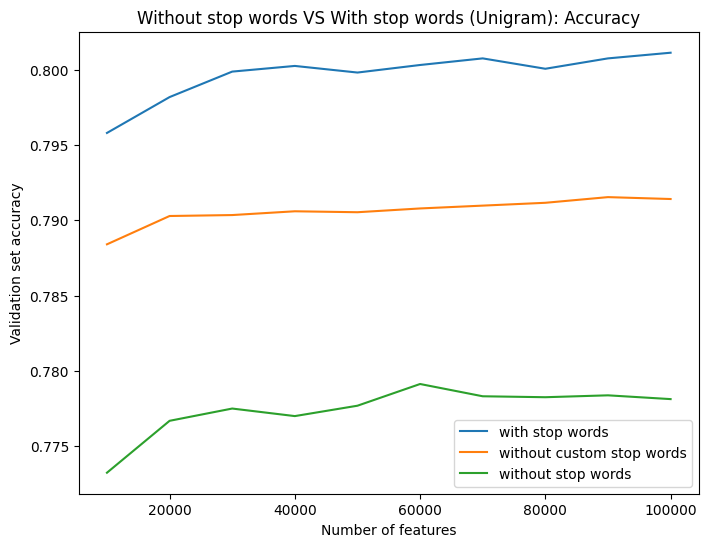

In [25]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
saveDF(nfeatures_plot_ug,"nfeatures_plot_ug.csv")
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
saveDF(nfeatures_plot_ug_wocsw,"nfeatures_plot_ug_wocsw.csv")
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])
saveDF(nfeatures_plot_ug_wosw,"nfeatures_plot_ug_wosw.csv")
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

Also experiment with ngrams

In [26]:
print("RESULT FOR BIGRAM WITH STOP WORDS")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
print("RESULT FOR TRIGRAM WITH STOP WORDS")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR BIGRAM WITH STOP WORDS
LogisticRegression(max_iter=200)


Validation result for 10000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 80.71%
model is 30.16% more accurate than null accuracy
train and test time: 68.38s
--------------------------------------------------------------------------------
Validation result for 20000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 81.35%
model is 30.81% more accurate than null accuracy
train and test time: 76.31s
--------------------------------------------------------------------------------
Validation result for 30000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 81.72%
model is 31.18% more accurate than null accuracy
train and test time: 76.52s
--------------------------------------------------------------------------------
Validation result for 40000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.00%
model is 31.45% more accurate than null accuracy
train and test time: 78.21s
--------------------------------------------------------------------------------
Validation result for 50000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.03%
model is 31.48% more accurate than null accuracy
train and test time: 79.33s
--------------------------------------------------------------------------------
Validation result for 60000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.07%
model is 31.53% more accurate than null accuracy
train and test time: 81.29s
--------------------------------------------------------------------------------
Validation result for 70000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.25%
model is 31.70% more accurate than null accuracy
train and test time: 81.61s
--------------------------------------------------------------------------------
Validation result for 80000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.36%
model is 31.81% more accurate than null accuracy
train and test time: 83.56s
--------------------------------------------------------------------------------
Validation result for 90000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.24%
model is 31.70% more accurate than null accuracy
train and test time: 85.64s
--------------------------------------------------------------------------------
Validation result for 100000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.37%
model is 31.82% more accurate than null accuracy
train and test time: 85.90s
--------------------------------------------------------------------------------
RESULT FOR TRIGRAM WITH STOP WORDS
LogisticRegression(max_iter=200)


Validation result for 10000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 80.74%
model is 30.19% more accurate than null accuracy
train and test time: 124.01s
--------------------------------------------------------------------------------
Validation result for 20000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 81.27%
model is 30.73% more accurate than null accuracy
train and test time: 138.59s
--------------------------------------------------------------------------------
Validation result for 30000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 81.81%
model is 31.27% more accurate than null accuracy
train and test time: 136.68s
--------------------------------------------------------------------------------
Validation result for 40000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.05%
model is 31.50% more accurate than null accuracy
train and test time: 136.50s
--------------------------------------------------------------------------------
Validation result for 50000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.11%
model is 31.57% more accurate than null accuracy
train and test time: 138.55s
--------------------------------------------------------------------------------
Validation result for 60000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.11%
model is 31.57% more accurate than null accuracy
train and test time: 137.35s
--------------------------------------------------------------------------------
Validation result for 70000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.28%
model is 31.74% more accurate than null accuracy
train and test time: 137.56s
--------------------------------------------------------------------------------
Validation result for 80000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.24%
model is 31.70% more accurate than null accuracy
train and test time: 138.47s
--------------------------------------------------------------------------------
Validation result for 90000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.24%
model is 31.69% more accurate than null accuracy
train and test time: 140.84s
--------------------------------------------------------------------------------
Validation result for 100000 features


/mnt/c/Users/facun/Ubuntu/projects/sentiment-analysis/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


null accuracy: 50.55%
accuracy score: 82.23%
model is 31.69% more accurate than null accuracy
train and test time: 139.79s
--------------------------------------------------------------------------------


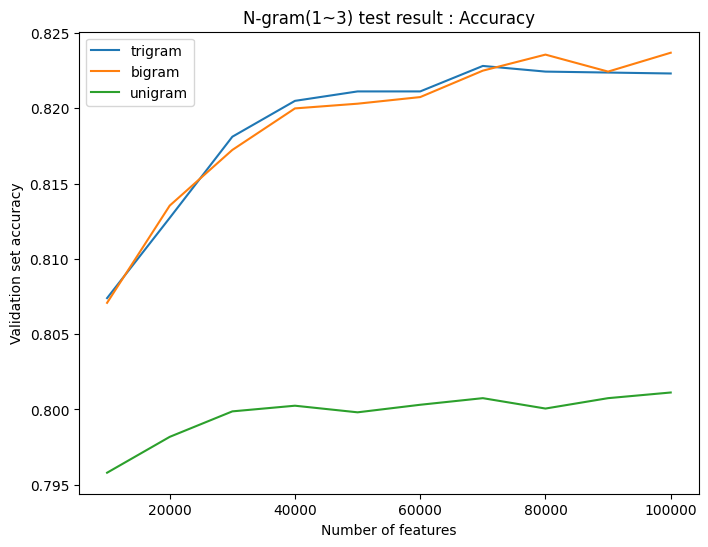

In [27]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
saveDF(nfeatures_plot_tg,"nfeatures_plot_tg.csv")
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
saveDF(nfeatures_plot_bg,"nfeatures_plot_bg.csv")
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

And explore the confusion matrixes

In [ ]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    print("Confusion Matrix")
    print(confusion)
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))